![](../docs/banner.png)

# Chapter 7: Advanced Deep Learning

**By [Tomas Beuzen](https://www.tomasbeuzen.com/) 🚀**

![](img/force.png)

## Chapter Outline
<hr>

<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Learning-Objectives" data-toc-modified-id="Chapter-Learning-Objectives-2">Chapter Learning Objectives</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li><li><span><a href="#1.-Autoencoders" data-toc-modified-id="1.-Autoencoders-4">1. Autoencoders</a></span></li><li><span><a href="#2.-Generative-Adversarial-Networks-(GANs)" data-toc-modified-id="2.-Generative-Adversarial-Networks-(GANs)-5">2. Generative Adversarial Networks (GANs)</a></span></li><li><span><a href="#3.-Multi-input-Networks" data-toc-modified-id="3.-Multi-input-Networks-6">3. Multi-input Networks</a></span></li><li><span><a href="#4.-Things-I-Haven't-Talked-About" data-toc-modified-id="4.-Things-I-Haven't-Talked-About-7">4. Things I Haven't Talked About</a></span></li><li><span><a href="#5.-Tom's-Cheat-Sheet" data-toc-modified-id="5.-Tom's-Cheat-Sheet-8">5. Tom's Cheat Sheet</a></span></li></ul></div>

## Chapter Learning Objectives
<hr>

- Describe what an autoencoder is at a high level and what they can be useful for.
- Describe what a generative adversarial network is at a high level and what they can be useful for.
- Describe what a multi-input model is and what they can be useful for.

## Imports
<hr>

In [22]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, utils, models
from torchsummary import summary
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from utils.plotting import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})

## 1. Autoencoders
<hr>

Autoencoders (AE) are networks that are designed to reproduce their input at the output layer. They are composed of an "encoder" and "decoder". The hidden layers of the AE are typically smaller than the input layers, such that the dimensionality of the data is reduced as it is passed through the encoder, and then expanded again in the decoder:

![](img/autoencoder.png)

Why would you want to use such a model? As you can see, AEs perform dimensionality reduction by learning to represent your input features using fewer dimensions. That can be useful for a range of tasks but we'll look at some specific examples below.

### 1.1. Example 1: Dimensionality Reduction

Here's some synthetic data of three features and two classes. Can we reduce the dimensionality of this data to two features while preserving the class separation?

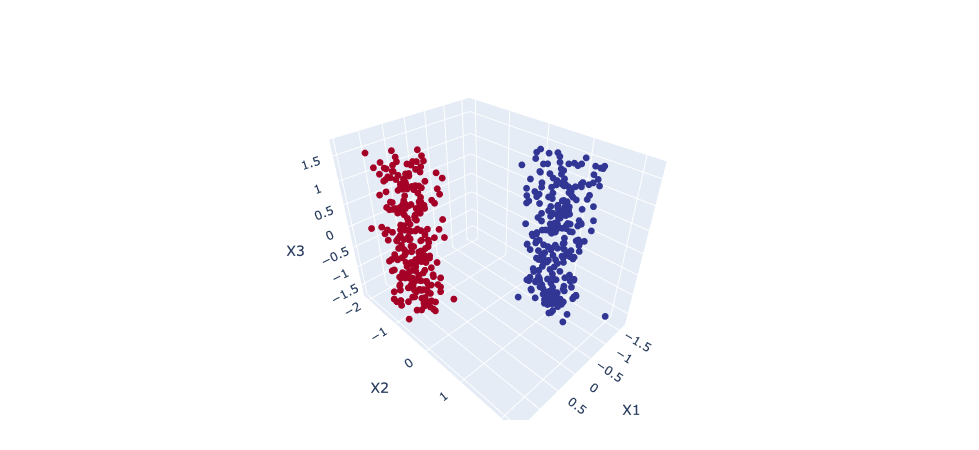

In [2]:
n_samples = 500
X, y = make_blobs(n_samples, n_features=2, centers=2, cluster_std=1, random_state=123)
X = np.concatenate((X, np.random.random((n_samples, 1))), axis=1)
X = StandardScaler().fit_transform(X)
plot_scatter3D(X, y)

We can see that `X1` and `X2` split the data nicely, and the `X3` is just noise. The question is, can an AE learn that this data can be nicely separated in just two of the three dimensions?

Let's build a simple AE with the following neurons in each layer: 3 -> 2 -> 3:

In [3]:
class autoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
BATCH_SIZE = 100
torch.manual_seed(1)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataloader = DataLoader(X_tensor,
                        batch_size=BATCH_SIZE)
model = autoencoder(3, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [5]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for batch in dataloader:
        optimizer.zero_grad()           # Clear gradients w.r.t. parameters
        y_hat = model(batch)            # Forward pass to get output
        loss = criterion(y_hat, batch)  # Calculate loss
        loss.backward()                 # Getting gradients w.r.t. parameters
        optimizer.step()                # Update parameters

We only care about the encoder now, does it represent our data nicely in reduced dimensions?

In [6]:
model.eval()
print(f"Original X shape = {X_tensor.shape}")
X_encoded = model.encoder(X_tensor)
print(f" Encoded X shape = {X_encoded.shape}")

Original X shape = torch.Size([500, 3])
 Encoded X shape = torch.Size([500, 2])


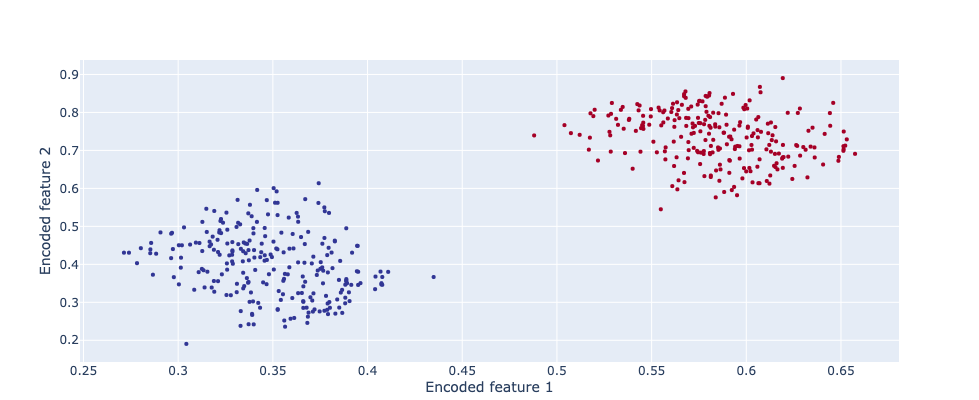

In [7]:
plot_scatter2D(X_encoded, y)

What did we just do? We used an AE to effectively reduce the number of features in our data.

### 1.2. Example 2: Image Denoising

Okay, let's do something more interesting. We saw above that AEs can be useful feature reducers (i.e., they can remove unimportant features from our data). This also applies to images and it's a fun application to de-noise images!

Take a look at these images of 8's from the MNIST dataset, I'm going to mess them up by adding some noise to them:

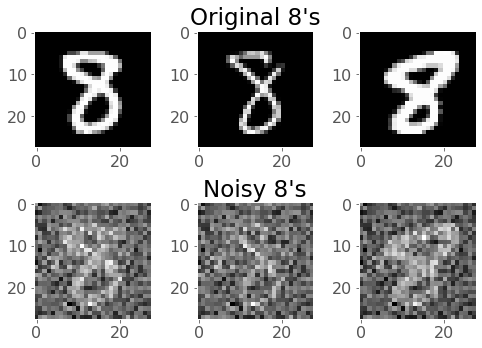

In [8]:
BATCH_SIZE = 32

# Download data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
idx = trainset.targets == 8  # let's only work with the number 8
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Sample plot
X, y = next(iter(trainloader))
noise = 0.5
plot_eights(X, noise)

Can we train an AE to get rid of that noise and reconstruct the original 8's? Let's give it a try!

I'm going to use convolutional layers in my AE now as we are dealing with images. We'll use `Conv2D()` layers to *compress* our images into a reduced dimensonality, and then we need to "upsample" it back to the original size. One ingredient you'll need to know to do this is "transposed convolutional layers". These are just like "convolutional layers" but for the purpose of "upsampling" (increasing the size of) our data. Rather than simply expanding the size of our data and interpolating, we use 
`nn.ConvTranspose2d()` layers to help us learn how to best upsample our data:

![](img/conv_trans_1.gif)

![](img/conv_trans_2.gif)

>Source: modified from [A guide to convolution arithmetic for deep learning, Vincent Dumoulin (2018)](https://arxiv.org/abs/1603.07285)

In [9]:
def conv_block(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)  # reduce x-y dims by two; window and stride of 2
    )

def deconv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2),
        nn.ReLU()
    )

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 16),
            conv_block(16, 8)
        )
        self.decoder = nn.Sequential(
            deconv_block(8, 8, 3),
            deconv_block(8, 16, 2),
            deconv_block(16, 32, 2),
            nn.Conv2d(32, 1, 3, padding=1)  # final conv layer to decrease channel back to 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # get pixels between 0 and 1
        return x

So we want to train our model to remove that noise I added. Generally speaking, the idea is that the model learns what pixel values are important, we are reducing the dimensionality of the imaages, so our model must learn only the crucial information (i.e., not the noise) needed to reproduce the image. Right now, our model probably produces gibberish because it isn't trained:

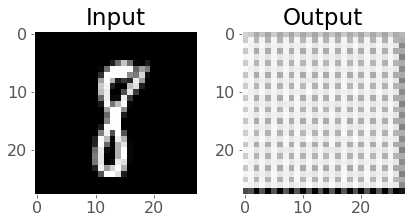

In [10]:
model = autoencoder()
input_8 = X[:1, :1, :, :]
output_8 = model(input_8)
plot_eight_pair(input_8, output_8)

How do we train it? Well we feed in a noisy image, compare it to the non-noisy version, and let the network learn how to make that happen. We want the value of the predicted pixels to be as close as possible to the real pixel values, so we'll use `MSELoss()` as our loss function:

In [ ]:
EPOCHS = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
img_list = []

for epoch in range(EPOCHS):
    losses = 0
    for batch, _ in trainloader:
        noisy_batch = batch + noise * torch.randn(*batch.shape)
        noisy_batch = torch.clip(noisy_batch, 0.0, 1.0)
        optimizer.zero_grad()
        y_hat = model(noisy_batch)
        loss = criterion(y_hat, batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"epoch: {epoch + 1}, loss: {losses / len(trainloader):.4f}")
    # Save example results each epoch so we can see what's going on
    with torch.no_grad():
        noisy_8 = noisy_batch[:1, :1, :, :]
        model_8 = model(input_8)
        real_8 = batch[:1, :1, :, :]
    img_list.append(utils.make_grid([noisy_8[0], model_8[0], real_8[0]], padding=1))

```C
epoch: 1, loss: 0.0914
epoch: 2, loss: 0.0501
epoch: 3, loss: 0.0431
...
epoch: 28, loss: 0.0275
epoch: 29, loss: 0.0273
epoch: 30, loss: 0.0273
```

In [ ]:
%%capture
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title("Input        Prediction        Actual")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani.save('eights.gif', writer='imagemagick', fps=2)
# HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

![](img/eights.gif)

Pretty cool!

## 2. Generative Adversarial Networks (GANs)
<hr>

### 2.1. What are GANs?

[GANs](https://arxiv.org/abs/1406.2661) were invented in 2014 by Ian Goodfellow and colleagues. GANs are pretty complex but they are just so cool so I wanted to talk about them briefly. The goal of a GAN is to develop a model that can generate realistic "fake" data, like the face below.
>If you look closely, you'll notice that some things don't look quite right, like the glasses...

![](img/fake-face.jpeg)

>Source: modified from [thispersondoesnotexist.com](https://thispersondoesnotexist.com/)

GANs are mostly used to generate imagery at the moment so I'll speak about them in that context. The "adversarial" comes from the fact that we actually have two networks "battling" each other:
1. The "Generator": takes some noise (like Gaussian noise) as input and generates "fake" data (like an image)
2. The "Discriminator": takes in real and fake data from the generator and attempts to classify it as "real" or "fake"

![](img/gan.png)

An analogy always helps. Think of the "Generator" as a new counterfeit artist trying to produce realistic-looking famous artworks to sell:

![](img/art.png)

The "Discriminator" is an art-critic, trying to determine if a piece of art is "real" or "fake". At first, the "Generator" produces poor art-replicas which the "Discriminator" can easily tell are fake.

![](img/fake.png)

But over time, the "Generator" learns ways to produce art that fools the "Discriminator". Eventually, the "Generator" gets so good, that the "Discriminator" can't tell if a piece of art is real or fake - the "Generator" is now able to generate realistic fake artwork! Money, money, money!

![](img/art-2.png)

GANs are mostly used to generate imagery at the moment so I'll focus on that. Training a GAN really happens in two iterative phases:
1. **Train the Discriminator:**
    - Generate some fake images with the generator
    - Show the discriminator real images and fake images and get it to classify them correctly (a simple binary classification problem)
2. **Train the Generator:**
    - Generate fake images with the generator but label them as "real"
    - At first, the discriminator will easily identify the "fake" images as "fake" (it's already been trained a little bit to do this)
    - This means the generator will have a large loss (the discriminator predicted the images as "fake" but the label is "real")
    - We use this loss to update the generator's weights. Next time around, the loss will be less, because the generator will produce some images that the discriminator thinks are real.
3. **Repeat!**

Enough talk, let's code it up!

### 2.2. An Example: Generating Bitmojis

I'm going to use our favourite bitmoji dataset to try and develop a GAN (this may or may not go well):

In [11]:
# Training Parameters
IMAGE_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE = 100
NUM_EPOCHS = 200  # we often need a lot of epochs to train GANs
LR = 0.0008
IMAGE_DIR = "data/bitmoji_rgb/all/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
# Loader
bitmoji_dataset = datasets.ImageFolder(root=IMAGE_DIR, transform=data_transforms)
bitmoji_loader = torch.utils.data.DataLoader(bitmoji_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using device: cpu


I'm going to base my architecture off the one in the original [Deep Convolutional (DCGAN) paper](https://arxiv.org/pdf/1511.06434.pdf). Here's the generator (the disciminator is the inverse of this):

![](img/dcgan-generator.png)

This is pretty complex stuff, but amazingly, we know what all of this is going to mean. Let's create the "Generator" first:

In [12]:
def convtrans_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Generator(nn.Module):
    def __init__(self, LATENT_SIZE):
        super().__init__()
        self.main = nn.Sequential(
            convtrans_block(LATENT_SIZE, 512, 4, stride=1, padding=0),
            convtrans_block(512, 256, 4, stride=2, padding=1),
            convtrans_block(256, 128, 4, stride=2, padding=1),
            convtrans_block(128, 64, 4, stride=2, padding=1),
            convtrans_block(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

We should be able to pass some noise to our generator and it will spit out an image (probably not a good one yet, as we haven't trained!):

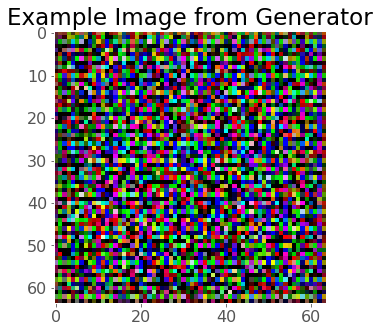

In [13]:
generator = Generator(LATENT_SIZE)
example_noise = torch.randn(1, LATENT_SIZE, 1, 1)
fake = generator(example_noise).squeeze().detach()
plt.figure(figsize=(5, 5))
plt.title("Example Image from Generator")
plt.imshow(np.transpose(fake, (1, 2, 0)));

Now let's create discriminator:

In [14]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, True)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            conv_block(64, 128, 4, 2, 1),
            conv_block(128, 256, 4, 2, 1),
            conv_block(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

Let's make sure our discriminator is able to make a prediction:

In [15]:
discriminator = Discriminator()
fake = generator(example_noise)
discriminator(fake).item()

0.5285460352897644

Okay, we're almost ready to train, the DCGAN paper recommends initializing the GAN with values from a normal distribution. I'll talk more about this later, for now, I'm just going to run this function:

In [16]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator = Generator(LATENT_SIZE)
generator.apply(weights_init)
generator.to(device)
discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device);

Okay, we're ready to train. Our loss functions will be `BCEWithLogitsLoss()` - remember, the discriminator is just a binary classification network. However, because we train the generator and discriminator separately, we'll need two optimizers:

In [17]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)  # Fixed noise vector we'll use to track image generation evolution

I've meticulously commented each line in the following training loop, hopefully it's not too hard to follow!

In [ ]:
# Lists to keep track of progress
img_list = []
ITERS = 0

print("Begin training...")
for epoch in range(NUM_EPOCHS):
    
    for real_batch, _ in bitmoji_loader:

        ### STEP 1: train discriminator
        # Train with real data
        discriminator.zero_grad()
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float, device=device)  # Real labels
        output = discriminator(real_batch).view(-1)  # Forward pass real batch through discriminator
        loss_real = criterion(output, real_labels)   # Calculate discriminator loss on real batch
        loss_real.backward()                         # Calculate gradients for discriminator with backward pass
        D_real = output.mean().item()                # Avg. D output on real batch
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1, device=device)  # Generate some noise to feed to generator
        fake_batch = generator(noise)                                      # Generate fake images with generator using the noise vector
        fake_labels = torch.zeros_like(real_labels)           # Fake labels
        output = discriminator(fake_batch.detach()).view(-1)  # Forward pass fake batch through discriminator (detach the generator though! we don't want to backprop through it)
        loss_fake = criterion(output, fake_labels)            # Calculate discriminator loss on real batch
        loss_fake.backward()                                  # Calculate gradients for discriminator with backward pass
        D_fake = output.mean().item()                         # Avg. D output on fake batch
        
        # Update discriminator weights and store loss
        optimizerD.step()
        loss_dis = loss_real + loss_fake
        
        ### STEP 2: train generator
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)           # Forward pass fake batch through updated discriminator
        loss_gen = criterion(output, real_labels)             # Calculate generator loss on fake batch
        loss_gen.backward()                                   # Calculate gradients for generator with backward pass
        
        # Update generator weights and store loss
        optimizerG.step()
        
        
        ### Print performance info every 50 iterations (weight updates)
        if ITERS % 50 == 0:
            print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})",
                  f"Iteration ({ITERS + 1})",
                  f"Loss_G: {loss_gen.item():.4f}",
                  f"Loss_D: {loss_dis.item():.4f}",
                  f"D_real: {D_real:.4f}",  # this should start around 1 and go down to 0.5 over time because
                                            # the discriminator can easily tell real images are real at first,
                                            # but as the generator gets better, the discriminator becomes unsure
                  f"D_fake: {D_fake:.4f}")  # this should start around 0 and go up to 0.5 over time, see above.

        ITERS += 1
    
    ### Keep a record of image generation as epochs progress
    if epoch % 2 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, nrow=4, normalize=True))
        
        
print("Finished training!")

```C
Begin training...
Epoch (1/200) Iteration (1) Loss_G: 1.7893 Loss_D: 3.2550 D_real: 0.2664 D_fake: 0.3662
Epoch (2/200) Iteration (51) Loss_G: 3.4757 Loss_D: 0.8228 D_real: 0.8536 D_fake: 0.2715
Epoch (3/200) Iteration (101) Loss_G: 4.5845 Loss_D: 0.5271 D_real: 0.8543 D_fake: 0.1388
Epoch (5/200) Iteration (151) Loss_G: 5.2458 Loss_D: 0.2388 D_real: 0.9584 D_fake: 0.1332
...
```

Now, here's a fancy animation that shows how our generator got better over time. I could have trained for longer, but the results are pretty cool!

In [ ]:
%%capture
fig = plt.figure(figsize=(6,6))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani.save('bitmoji.gif', writer='imagemagick', fps=2)
# HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

![](img/bitmoji-gan.gif)

## 3. Multi-input Networks
<hr>

Sometimes you'll want to combine different types of data in a single network. The most common case is combining tabular data with image data, for example, using both real estate data and images of a house to predict its sale price:

![](img/multi-input.png)

Source: "[House](https://www.flickr.com/photos/68089229@N06/17458373552)" by [oatsy40](https://www.flickr.com/photos/68089229@N06), "[House in Vancouver](https://www.flickr.com/photos/17573364@N00/433449690)" by [pnwra](https://www.flickr.com/photos/17573364@N00), "[House](https://www.flickr.com/photos/21098413@N04/5405425139)" by [noona11](https://www.flickr.com/photos/21098413@N04) all licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/?ref=ccsearch&atype=rich).

In such a problem you may want to combine:
1. a NN for the tabular data
2. a CNN for the image data

The way we often do this is create these two models, and then combine them together into a model that produces a single output. This sounds complicated but it's pretty easy! We only need one new ingredient which is a concatenation function: `torch.cat()`. Below is a simple example:

In [18]:
class MultiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 8, 5, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1800, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )
        
        self.multi = nn.Sequential(
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
    def forward(self, image, data):
        x_cnn = self.cnn(image)
        x_fc = self.fc(data)
        x_multi = torch.cat((x_cnn, x_fc), dim=1)
        return self.multi(x_multi)

In [20]:
model = MultiModel()
image = torch.randn(1, 3, 64, 64)
data = torch.randn(1, 10)
model(image, data).item()

-0.20222929120063782

The above network doesn't really do anything but show that we can easily combine a CNN and fully connected NN!

## 4. Things I Haven't Talked About
<hr>

We've talked about a lot in this course, but there's a lot I haven't talked about too!

- Recurrent neural networks (good for sequential data like text and time series)
- Bayesian neural networks (in one sentence: capture uncertainty by learning a distribution over the network parameters rather than learning point estimates)
- Training at scale/distributed computing
- Working with other forms of data like time series, text, audio, video, etc.
- [Pruning](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) (removing unnecessary weights from a deep network) and [quantization](https://pytorch.org/docs/stable/quantization.html) (use a small data type for model weights and operations, e.g., integers rather than floats) to reduce memory foot print and increase speed
- High-level PyTorch APIs: [Ignite](https://github.com/pytorch/ignite), [Skorch](https://github.com/skorch-dev/skorch), [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning), etc.
- Adversarial examples. In one sentence: this is about "tricking" a model by adding some artifact, like noise, to the input image. See this [OpenAI blog post](https://openai.com/blog/adversarial-example-research/) or some work on [adversarial stickers](https://arxiv.org/pdf/1904.00759.pdf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


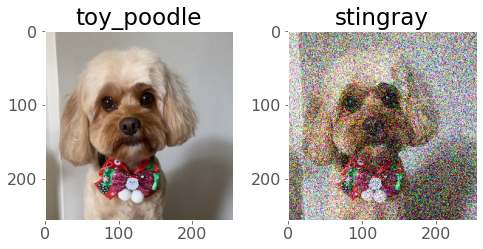

In [23]:
densenet = models.densenet121(pretrained=True)
densenet.eval()
classes = json.load(open("data/imagenet_class_index.json"))
idx2label = [classes[str(k)][1] for k in range(len(classes))]
torch.manual_seed(0)
image = Image.open('img/evie.png')
image = transforms.functional.to_tensor(image).unsqueeze(0)
image_noise = image + 0.30 * torch.randn_like(image)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
_, image_noise_idx = torch.softmax(densenet(image_noise), dim=1).topk(1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
ax1.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
ax1.set_title(f"{idx2label[image_idx.item()]}")
ax2.imshow(np.transpose(image_noise.squeeze(), (1, 2, 0)))
ax2.set_title(f"{idx2label[image_noise_idx.item()]}")
plt.tight_layout();

- Weight initiailization in layers: The intial weights of your network can affect the final result of your optimization. The general rule for setting the weights in a neural network is to set them to be close to zero without being too small. PyTorch does this for you automatically, but if you want to make your code exactly reproducible and be in control of the initialization, you can do that too. It's easy to do in PyTorch using the `.apply()` method:

```python
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)
```

In [24]:
class example(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 3, (3, 3)),
            nn.Flatten(),
            nn.Linear(2028, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [26]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

torch.manual_seed(123)
model = example()
model.apply(weights_init);

Initializing weights of a Conv2d layer!
Initializing weights of a Linear layer!
Initializing weights of a Linear layer!


## 5. Tom's Cheat Sheet
<hr>

I thought it might be helpful to write down the general guidelines I follow when approaching a new data modelling problem.


**TABULAR DATA**
- Classification:
    1. Logisitic Regression + feature engineer
    2. XGBoost / LGBM + feature engineer
    3. Neural network + feature engineer
- Regression:
    1. Linear Regression + feature engineer
    2. XGBoost / LGBM + feature engineer
    3. Neural network + feature engineer

**IMAGE DATA**
- Use a CNN:
    - Option 1: if data is relatively simple, develop CNN from scratch:
        - Start with 3x3 filters with strides of 1 or 2
        - Number of filters proprtional to data complexity, usually 4, 8, 16, 24
        - The first convolutional layer should have more channels that the input data
    - Option 2: transfer learning
    
**TIME SERIES DATA**
1. AutoRegressive Integrated Moving Average (ARIMA)
2. XGBoost / LGBM + feature engineer
3. Recurrent neural network (RNN)

**AUDIO, VIDEO, OTHER**
- Probably some kind of NN